# Scalable Gaussian Process Deep Learning
*MADSTARE LDRD machine learning tutorials*

In this tutorial we will expand upon the use of the Gaussian Process (GP) analog to wide, deep neural networks. We will use the MNIST hand-written digits data set as the example for study and compare with the performance of a neural network from the [TensorFlow library tutorial example for MNIST](https://www.tensorflow.org/tutorials), as well as an implementation of Lee, Bahri et al.'s neural network Gaussian process (nngp) [Deep Neural Networks as Gaussian Processes](https://arxiv.org/abs/1711.00165).

## Deep Neural Networks


# MNIST Image Classification
As discussed previously, MNIST is a normalized set $\left \{x_i \right \}_{i = 1}^N$ of $N$ $d = 28 * 28 = 784$ pixel images, each associated with a single-digit numeral. We want an system that can automatically assign the correct numeral label to a previously-unseen image. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gpnn

from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(context='notebook', fscale=1.5, figsize=(8.0, 8.0/1.618))

We will load the MNIST dataset and display some images.

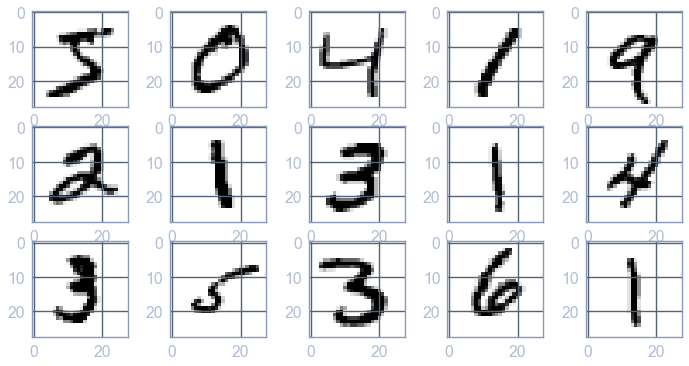

In [2]:
import tensorflow as tf
mnist_keras = tf.keras.datasets.mnist
(x_train_full, y_train_full),(x_test_full, y_test_full) = mnist_keras.load_data()
x_train_full, x_test_full = x_train_full / 255.0, x_test_full / 255.0

im_nx, im_ny = x_train_full.shape[1:3]

fig = plt.figure(figsize=(12,6))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_train_full[i,:,:], cmap=plt.cm.gray_r)

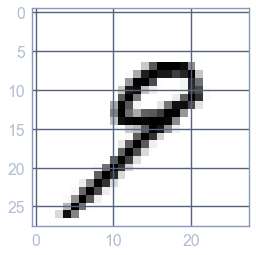

In [3]:
plt.imshow(x_train_full[501,:,:], cmap=plt.cm.gray_r)

## Neural Network Gaussian Process
We will classify MNIST using an NNGP. 

In [4]:
def convert_to_one_hot(a, num_labels=10):
    b = np.zeros((a.shape[0], num_labels))
    b[np.arange(a.shape[0]), a] = 1
    return b

def get_gp_data_subset(n_train=500, n_test=500):
    x_flat = np.row_stack((x_train_full[0:n_train, ...].reshape((n_train, im_nx*im_ny)),
                           x_test_full[0:n_test, ...].reshape(n_test, im_nx*im_ny)))
    return x_flat

In [5]:
n_train = 500
n_test = 500

We prepare the image data for regression by stacking the flattened images and normalizing each row of the data array to have constant variance.

In [6]:
x_gp = get_gp_data_subset()
x = gpnn.util.normalize(x_gp)

We use a one-hot encoding, adjusted according to recent conventions to have zero mean. Accordingly, a label of e.g. 3 is converted to the 10-vector $e_3 - 0.1 \mathbb{1} = [0, 0, 0, 3, 0, 0, 0, 0, 0, 0]^T$.

In [7]:
labels_train = convert_to_one_hot(y_train_full[0:n_train]) - 0.1
labels_test = convert_to_one_hot(y_test_full[0:n_test]) - 0.1

### Kernel construction

Now it's time to construct the GP kernel. 

The kernel has two parameters corresponding to the variances in the zero-mean Gaussian priors on the neural net node weights ($\sigma_w^2$) and biases ($\sigma_b^2$). We'll adopt the values learned from the grid search in predictive performance accuracy from the Google Brain paper in 2017. 

In [8]:
sigma_w_sq = 1.79
sigma_b_sq = 0.83

The kernel also requires specification of the number 'layers'. This is the number of iterations in the recursive composition of the kernel, which mimics the layers in a deep fully-connected feed forward network. We'll choose 100 layers to match the first entry in Table 2 of the Google Brain paper.

In [9]:
L = 100

Now, we build the kernel gram matrix for the selected training and test data using the analytic form for the ReLu activation.

(This can take a couple of minutes to run.)


In [10]:
# print("Test accuracy: {:5.4f}".format(np.sum(np.equal(np.argmax(post_mean, 1), 
#                                                       np.argmax(labels_test, 1))
#                                             ) / float(n_test)))

# The N4GP: Quality and Speed analysis

In [11]:
import pyNNGP
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

In [12]:
x_gp = get_gp_data_subset(n_train=500, n_test=500)

In [13]:
def make_n4gp(labels, x, L=30, sigmaSqW=1.84, sigmaSqB=0.04, noise=0.01, nNeighbors=20):
    covModel = pyNNGP.NNKernel(
        L=L, sigmaSqW=sigmaSqW, sigmaSqB=sigmaSqB
    )
    
    noiseModel = pyNNGP.ConstHomogeneousNoiseModel(noise)

    distFunc = pyNNGP.DotProduct()

    # fit the model
    n4gp = pyNNGP.SeqNNGP(
        labels, x,
        nNeighbors=nNeighbors,
        covModel=covModel,
        distFunc=distFunc,
        noiseModel=noiseModel,
        normalize=True
    )
    return n4gp

In [14]:
def n4gp_compute(num_train, num_test, L=30, sigmaSqW=1.84, sigmaSqB=0.04, noise=0.01, nNeighbors=10):
    x_gp = get_gp_data_subset(n_train=num_train, n_test=num_test)
    x_train = x_gp[0:num_train]
    x_test = x_gp[num_train:]
    labels_train = convert_to_one_hot(y_train_full[0:num_train]) - 0.1
    labels_test = convert_to_one_hot(y_test_full[0:num_test]) - 0.1
    
    n4gp = make_n4gp(labels_train, x_train, L=L, sigmaSqW=sigmaSqW, sigmaSqB=sigmaSqB, noise=noise, nNeighbors=nNeighbors)

    post_mean = n4gp.MAPPredict(x_test)
    return post_mean

In [15]:
n4gp = make_n4gp(labels_train, x_gp[0:n_train])

In [16]:
post_mean, Xstar = n4gp_compute(500, 1)

In [17]:
Xstar.shape

(784, 1)

In [18]:
np.linalg.norm(Xstar, axis=0)

array([10.77032961])

In [19]:
post_mean.shape

(10, 500)

In [20]:
np.any(np.isnan(post_mean))

False

In [21]:
post_mean

array([[-1.00000000e-01,  9.99002826e-01, -4.96936829e-01, ...,
        -1.27223774e-01, -5.90964689e-01, -1.34295093e-01],
       [-1.00000000e-01, -9.97174388e-04, -6.30002691e-04, ...,
        -7.37880727e-02, -2.05161795e-04, -1.74220840e-04],
       [-1.00000000e-01, -9.97174388e-04, -6.30002691e-04, ...,
        -1.10015430e-01, -2.05161795e-04, -1.74220840e-04],
       ...,
       [-1.00000000e-01, -9.97174388e-04, -6.30002691e-04, ...,
         7.76437729e-01, -2.86665386e-01, -3.54033065e-01],
       [-1.00000000e-01, -9.97174388e-04, -6.30002691e-04, ...,
        -1.65145004e-04, -2.05161795e-04,  9.99825779e-01],
       [-1.00000000e-01, -9.97174388e-04, -6.30002691e-04, ...,
        -2.12238123e-01, -2.05161795e-04, -9.82943329e-02]])

In [22]:
convert_to_one_hot(y_test_full[0:1]) - 0.1

array([[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,  0.9, -0.1, -0.1]])

In [23]:
n4gp.coeffs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
n4gp.F

array([ 6.15643207e-01,  5.05573991e-03,  3.58530114e-03,  2.06450043e-03,
        1.09084099e-03,  3.54316591e-04,  6.66570956e-04, -4.98557181e-04,
       -6.38081191e-04,  6.58794506e-05, -6.46505109e-04,  4.09321325e-04,
       -1.48334841e-04, -2.95451013e-04, -1.01135962e-03, -3.81631978e-04,
       -2.32757597e-04, -9.27466844e-04,  4.65885782e-05, -9.76421175e-04,
       -3.47083790e-04, -2.96633337e-04, -5.58432248e-04, -1.47127325e-04,
       -2.05941903e-04, -5.93870996e-04,  2.31038993e-05, -5.96472061e-04,
       -2.23479549e-04, -8.17828197e-05,  2.98481425e-05, -5.32672687e-04,
        2.19053019e-04, -3.39340920e-04, -6.36764841e-04,  8.60298941e-05,
       -3.68601946e-04, -5.12371096e-04,  9.42965096e-06, -3.33388810e-04,
        6.31695133e-05, -5.35766810e-04,  2.77631325e-04, -3.25603975e-04,
        2.86240062e-04, -2.12607884e-04, -2.07041043e-04,  1.02910716e-04,
        1.99513867e-04, -3.30884071e-04,  2.83984132e-04,  4.70745626e-05,
        2.39785880e-04, -

In [25]:
convert_to_one_hot(y_test_full[0:1]) - 0.1

array([[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,  0.9, -0.1, -0.1]])